In [1]:
import pandas as pd
import numpy as np

import rasterio as rio
from rasterio.windows import from_bounds
import geopandas as gpd
from geoutils import grid
from shapely.geometry import box, MultiPolygon,Polygon,shape

from sklearn.model_selection import ShuffleSplit

import matplotlib.pyplot as plt
import seaborn as sns

import os,sys

In [2]:
plt.style.use("bmh")

# Normlize Rasters

## S2

`The actual encoding of the Sentinel-2 sensor is 12 bits. In Sentinel images, the 16-bit encoding is used for convenience, because the Jpeg2000 driver, as most remote sensing images drivers, doesn’t support 12-bit encoding. But the actual digital number produced by the Sentinel-2 ground segment has 12-bit encoding.`

In [3]:
!ls ../data/s2/

05-07-2019  24-08-2019	25-07-2019


In [5]:
def normlization_s2(src,outPath):
    list_image_4328 = [rio.open(f'{src}/{img}').read() for img in ['B04.tif', 'B03.tif', 'B02.tif', 'B08.tif']]
    list_image_4328_norm = [img*0.00012207 for img in list_image_4328]
    S2_B4328_10m = np.concatenate(list_image_4328_norm)
    profile = rio.open(f'{src}/B02.tif').profile
    profile['count'] = 4
    profile['dtype'] = 'float32'
    
    with rio.open(outPath, 'w', **profile) as dst_dataset:
        dst_dataset.write(S2_B4328_10m.astype('float32'))

In [6]:
normlization_s2('../data/s2/05-07-2019','../data/S2_B4328_10m_05072019.tif')

In [7]:
normlization_s2('../data/s2/24-08-2019','../data/S2_B4328_10m_24082019.tif')

In [8]:
normlization_s2('../data/s2/25-07-2019','../data/S2_B4328_10m_25072019.tif')

## S1

`Still after colobration SAR images, the SAR speckle noise is still present in the calibrated images in the form of extreme values. Therefore, we clip all pixels values x where x > 1: the physical meaning of such values is that the sensor received more energy than it emitted (Filtering values). Finally, we transform the pixel values, using a linear function to map the absolute pixel values in the [0, 1] range.(Linear stretch)`

In [31]:
!ls ../data/s1/

S1A_IW_20190725T175553_DVP_RTC30_G_spuned_F947_VH_10m.tif
S1A_IW_20190725T175553_DVP_RTC30_G_spuned_F947_VH.tif
S1A_IW_20190725T175553_DVP_RTC30_G_spuned_F947_VV_10m.tif
S1A_IW_20190725T175553_DVP_RTC30_G_spuned_F947_VV.tif


In [32]:
list_image_s1 = [rio.open(f'../data/s1/{img}').read() for img in ['S1A_IW_20190725T175553_DVP_RTC30_G_spuned_F947_VH_10m.tif', 'S1A_IW_20190725T175553_DVP_RTC30_G_spuned_F947_VV_10m.tif']]

In [33]:
list_image_s1_filtered_values = [np.log(np.minimum(np.maximum(img,0.00001),1)) for img in list_image_s1]

In [34]:
list_image_s1_norm = [img / img.min() for img in list_image_s1_filtered_values]

In [35]:
S1_VH_VV_10m = np.concatenate(list_image_s1_norm)

In [36]:
profile = rio.open(f'../data/s1/S1A_IW_20190725T175553_DVP_RTC30_G_spuned_F947_VH_10m.tif').profile
profile['count'] = 2
profile['dtype'] = 'float32'

In [37]:
with rio.open('../data/s1/S1_VH_VV_10m_25072019.tif', 'w', **profile) as dst_dataset:
    dst_dataset.write(S1_VH_VV_10m.astype('float32'))

# Align S1 with S2

In [42]:
def exract_boundry(original_img,source_img, out_path):
    """
    original_img: The image should be mapped to the source image
    source_image: The image which should not be changed
    """
    original_ = rio.open(original_img)
    source_ = rio.open(source_img)
    minx,miny,maxx,maxy = source_.bounds
    window = from_bounds(minx, miny, maxx, maxy, transform=original_.transform)
    width=source_.width
    height=source_.height
    transform = rio.transform.from_bounds(minx,miny,maxx,maxy, width, height)
    result = original_.read(window=window,out_shape=(height,width),resampling=0)
    
    profile = original_.profile
    profile['transform'] = transform
    profile['width'] = width
    profile['height'] = height
    out_path = out_path
    with rio.open(out_path, 'w', **profile) as dst_dataset:
        dst_dataset.write(result.astype('float32'))

In [43]:
exract_boundry('../data/s1/S1_VH_VV_10m_25072019.tif','../data/S2_B4328_10m_25072019.tif', '../data/S1_VH_VV_10m_25072019_aligned.tif')

# Visulization Results

In [44]:
s2_image = rio.open('../data/S2_B4328_10m_25072019.tif').read([1,2,3])
s1_image = rio.open('../data/S1_VH_VV_10m_25072019_aligned.tif').read([1])

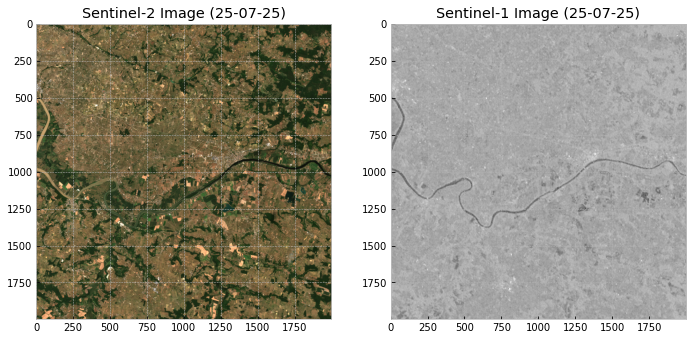

In [68]:
plt.figure(figsize=(18, 12))
plt.subplot(231)
plt.title('Sentinel-2 Image (25-07-25)')
plt.imshow(np.clip(np.moveaxis(s2_image,0,-1)[2000:4000,2000:4000,:]*3, 0, 1))
plt.subplot(232)
plt.title('Sentinel-1 Image (25-07-25)')
plt.imshow(np.moveaxis(s1_image,0,-1)[2000:4000,2000:4000,0]*5, cmap=plt.cm.gray_r)
# plt.colorbar(shrink=0.25)
plt.show()

# Prepare Patches

In [3]:
Xmin, Ymin, Xmax, Ymax = rio.open('../data/S2_B4328_10m_25072019.tif').bounds

In [4]:
g = grid.grid(Xmin, Xmax, Ymin, Ymax,cell_size=640,crs=32630)

In [5]:
patches = g.generate_grid()
patches.head()

,geom
0,"POLYGON ((700600.000 4890240.000, 700600.000 4..."
1,"POLYGON ((701240.000 4890240.000, 701240.000 4..."
2,"POLYGON ((701880.000 4890240.000, 701880.000 4..."
3,"POLYGON ((702520.000 4890240.000, 702520.000 4..."
4,"POLYGON ((703160.000 4890240.000, 703160.000 4..."


In [6]:
patches.shape

(29241, 1)

In [7]:
cloud_mask = gpd.read_file('../data/s2_cloud_mask.geojson')
cloud_mask.head()

,id,geometry
0,1,"MULTIPOLYGON (((759582.575 4961729.156, 762162..."
1,2,"MULTIPOLYGON (((699957.482 4981931.535, 699602..."
2,3,"MULTIPOLYGON (((778551.684 4907406.892, 782427..."
3,4,"MULTIPOLYGON (((751265.804 4913749.150, 751287..."
4,5,"MULTIPOLYGON (((748472.707 4911039.800, 748501..."


In [8]:
mp = MultiPolygon(cloud_mask.explode(index_parts=True).geometry.values)

In [9]:
patches_filter = patches[~patches.intersects(mp)]

In [10]:
patches_filter.shape

(25781, 1)

# Train-test Splits

In [59]:
# Get the split indexes for train and validation-test
strat_shuf_split = ShuffleSplit(n_splits=1, 
                                test_size=0.3, 
                                random_state=125)

train_idx, valid_test_idx = next(strat_shuf_split.split(patches_filter.geometry, patches_filter.index))

In [60]:
train_idx.shape,valid_test_idx.shape

((18046,), (7735,))

In [61]:
train_data = patches_filter.iloc[train_idx, :]
valid_test_data = patches_filter.iloc[valid_test_idx, :]

In [62]:
# Get the split indexes test and validation
strat_shuf_split = ShuffleSplit(n_splits=1, 
                                test_size=0.1, 
                                random_state=456)

valid_idx, test_idx = next(strat_shuf_split.split(valid_test_data.geometry, valid_test_data.index))

In [63]:
valid_idx.shape,test_idx.shape

((6961,), (774,))

In [64]:
test_data = valid_test_data.iloc[test_idx, :]
valid_data = valid_test_data.iloc[valid_idx, :]

In [66]:
train_data.to_file('../data/train_data.geojson', driver='GeoJSON')
valid_data.to_file('../data/valid_data.geojson', driver='GeoJSON')
test_data.to_file('../data/test_data.geojson', driver='GeoJSON')